In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from simulation import ElectricSystem

In [3]:
def read_parameters(
    excel_path: str, nrows_table_1: int, sheet_name: str = "Sheet1"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read parameters from an Excel file.

    Expects a single sheet with two tables separated by a blank line.

    Args:
        excel_path (str): path to Excel file with parameters
        nrows_table_1 (int): number of rows of first table
        sheet_name (str, optional): name of sheet with parameters. Defaults to "Sheet1".

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: two pandas dfs - each corresponds to one table in the Excel file
    """
    xl = pd.ExcelFile(excel_path)
    yearly_params: pd.DataFrame = xl.parse(sheet_name, nrows=nrows_table_1)  # type: ignore
    sources: pd.DataFrame = xl.parse(sheet_name, skiprows=(nrows_table_1 + 1))  # type: ignore
    return yearly_params, sources

In [4]:
yearly_params, sources = read_parameters("./parametry.xlsx", 3)
yearly_params = yearly_params.set_index("Rocni cyklus")

In [5]:
sources

,Zdroj,Vyroba [GWh],Instalovany vykon [MWe],Utilizace [%],Pocet bloku,Pravdepodobnost odstavky [%],Prumerna delka odstavky [dny],Priorita
0,Jadro,30000,4300,0.796432,6,10,20,2
1,Uhli,37000,9400,0.449334,12,20,10,3
2,Plyn,6000,2300,0.297796,6,20,8,4
3,FVE,2000,2100,0.108719,1,40,1,1


In [6]:
block_counts_raw = sources[["Zdroj", "Pocet bloku"]].to_dict(orient="records")
block_counts = []
for _, row in sources.iterrows():
    block_counts += [{"type": row["Zdroj"], "block_no": i} for i in range(row["Pocet bloku"])]
sources_long = pd.DataFrame(block_counts)
sources_long.head()

,type,block_no
0,Jadro,0
1,Jadro,1
2,Jadro,2
3,Jadro,3
4,Jadro,4


In [7]:
sources["power_per_block"] = (sources["Instalovany vykon [MWe]"] / sources["Pocet bloku"]).astype(int)
sources_long = sources_long.merge(
    sources[["Zdroj", "power_per_block", "Priorita", "Pravdepodobnost odstavky [%]"]].set_axis(
        ["type", "power", "priority", "shutdown_prob"], axis=1
    ),
    on="type",
)
# sources_long.set_index(["type", "block_no"], inplace=True)
sources_long

,type,block_no,power,priority,shutdown_prob
0,Jadro,0,716,2,10
1,Jadro,1,716,2,10
2,Jadro,2,716,2,10
3,Jadro,3,716,2,10
4,Jadro,4,716,2,10
5,Jadro,5,716,2,10
6,Uhli,0,783,3,20
7,Uhli,1,783,3,20
8,Uhli,2,783,3,20
9,Uhli,3,783,3,20


In [8]:
days = pd.Series(pd.date_range(start="2022-01-01", end="2022-12-31", freq="D"), name="date")

In [9]:
supply_daily = sources_long.merge(days, how="cross").set_index(["date", "type", "block_no"])

In [89]:
# np.random.random_sample(len(supply_daily))
np.random.default_rng().random(size)

array([0.45070984, 0.93952868, 0.74720427, ..., 0.74379997, 0.15717298,
       0.77452259])

In [10]:
supply_daily["available"] = np.random.random_sample(len(supply_daily)) > supply_daily["shutdown_prob"] / 100.0
supply_daily

,,,power,priority,shutdown_prob,available
date,type,block_no,,,,
2022-01-01,Jadro,0,716,2,10,True
2022-01-02,Jadro,0,716,2,10,True
2022-01-03,Jadro,0,716,2,10,True
2022-01-04,Jadro,0,716,2,10,True
2022-01-05,Jadro,0,716,2,10,True
...,...,...,...,...,...,...
2022-12-27,FVE,0,2100,1,40,False
2022-12-28,FVE,0,2100,1,40,False
2022-12-29,FVE,0,2100,1,40,False


In [11]:
supply_daily.loc[(slice(None), "Jadro", slice(None)), :]

,,,power,priority,shutdown_prob,available
date,type,block_no,,,,
2022-01-01,Jadro,0,716,2,10,True
2022-01-02,Jadro,0,716,2,10,True
2022-01-03,Jadro,0,716,2,10,True
2022-01-04,Jadro,0,716,2,10,True
2022-01-05,Jadro,0,716,2,10,True
...,...,...,...,...,...,...
2022-12-27,Jadro,5,716,2,10,True
2022-12-28,Jadro,5,716,2,10,True
2022-12-29,Jadro,5,716,2,10,True


In [12]:
supply_daily["available_power"] = supply_daily["power"] * supply_daily["available"]
supply_daily.reset_index(inplace=True)
plot_data = supply_daily.groupby(["date", "type"]).sum()["available_power"].reset_index()
plot_data

,date,type,available_power
0,2022-01-01,FVE,2100
1,2022-01-01,Jadro,2864
2,2022-01-01,Plyn,1532
3,2022-01-01,Uhli,6264
4,2022-01-02,FVE,0
...,...,...,...
1455,2022-12-30,Uhli,7830
1456,2022-12-31,FVE,2100
1457,2022-12-31,Jadro,3580
1458,2022-12-31,Plyn,1915


In [103]:
pd.DataFrame(es.demand["demand_MWh"], index=days).reset_index()

,date,demand_MWh
0,2022-01-01,11805.555556
1,2022-01-02,11805.349777
2,2022-01-03,11804.732501
3,2022-01-04,11803.703912
4,2022-01-05,11802.264313
...,...,...
360,2022-12-27,11800.414132
361,2022-12-28,11802.264313
362,2022-12-29,11803.703912
363,2022-12-30,11804.732501


<Axes: >

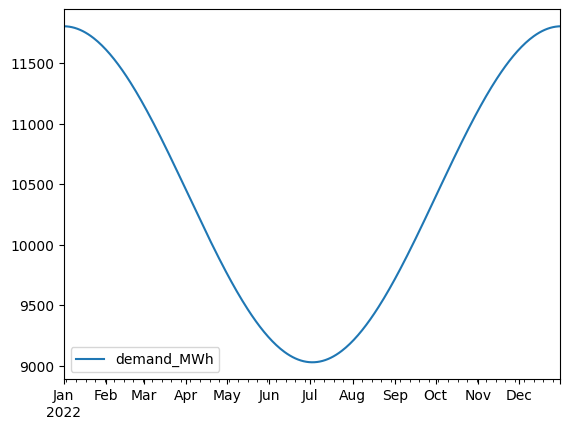

In [16]:
es = ElectricSystem()
es.set_demand(*yearly_params.loc["Spotreba [GWh]"])
es.set_sources(sources, *yearly_params.loc["Utilizace FVE [%]"])

es.demand.plot.line()

<Axes: xlabel='date', ylabel='Count'>

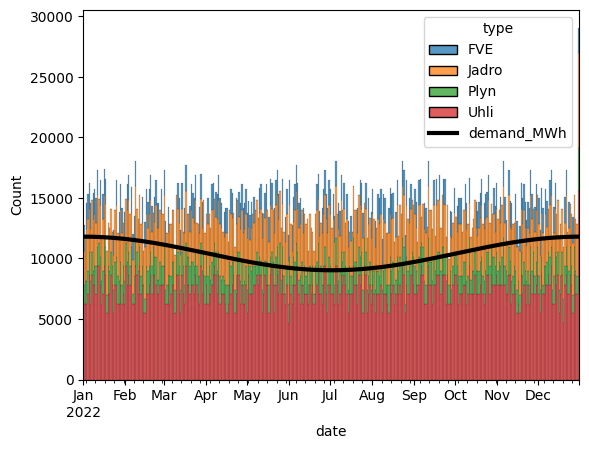

In [19]:
ax = sns.histplot(plot_data, binwidth=1, x="date", hue="type", weights="available_power", multiple="stack")
es.demand.plot.line(ax=ax, color="black", lw=3)

In [137]:
def _custom_cosine_wave(index: pd.Index, january: float, july: float, column_name: str = "wave") -> pd.Series:
    """
    Generate custom cosine wave that has predefined extremes in January and July.

    Args:
        january (float): maximum/minimum value, achieved in January
        july (float): minimum/maximum value, achieved in July
        column_name (str): name of value column in the final series

    Returns:
        pd.Series: series with calendar days as index, smooth wave in values
    """
    cosine_wave = np.cos(np.linspace(0, 2 * np.pi, len(index), endpoint=False))
    wave = (cosine_wave + 1) / 2 * (january - july) + july
    return pd.Series(wave, index=index, name=column_name)


def prepare_demand(days: pd.DataFrame, january_demand_monthly: float, july_demand_monthly: float) -> pd.DataFrame:
    """
    Fill the df with mean hourly demand in MWh.
    The seasonal changes are approximated by a cosine wave with extremes in January and July.

    Args:
        days (pd.DataFrame): time dimension, daily granularity
        january_demand_monthly (float): monthly demand in January in MWh, extreme value (usually maximum)
        july_demand_monthly (float): monthly demand in July in MWh, extreme value (usually minimum)

    Returns:
        pd.DataFrame: mean hourly demand in MWh with daily granularity
    """
    demand_hourly_january_MWh = january_demand_monthly / 30 / 24
    demand_hourly_july_MWh = july_demand_monthly / 30 / 24

    demand_curve = _custom_cosine_wave(
        index=days.set_index("date").index,
        january=demand_hourly_january_MWh,
        july=demand_hourly_july_MWh,
        column_name="demand",
    )
    return days.merge(demand_curve.reset_index())


days = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31", freq="D"), columns=["date"])
# demand_curve = _custom_cosine_wave(
#     index=days.set_index("date").index,
#     january=10,
#     july=20,
#     column_name="demand",
# )
# days.merge(demand_curve.reset_index())
prepare_demand(days, 10, 20)

,date,demand
0,2022-01-01,0.013889
1,2022-01-02,0.013890
2,2022-01-03,0.013893
3,2022-01-04,0.013898
4,2022-01-05,0.013905
...,...,...
360,2022-12-27,0.013915
361,2022-12-28,0.013905
362,2022-12-29,0.013898
363,2022-12-30,0.013893


<Axes: >

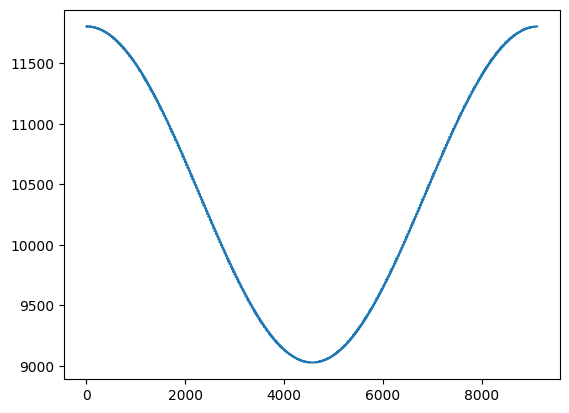

In [112]:
supply_daily["demand_MWh"].plot.line()

<Axes: xlabel='date'>

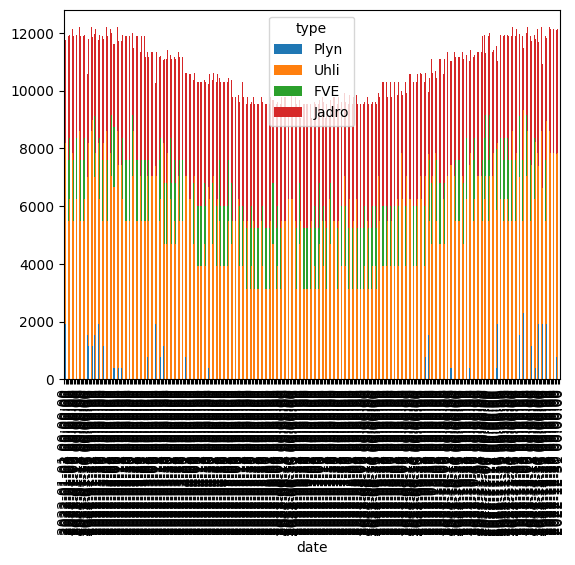

In [110]:
plot_data.pivot_table(values="final_power", index="date", columns="type").plot.bar(stacked=True)

<Axes: xlabel='date'>

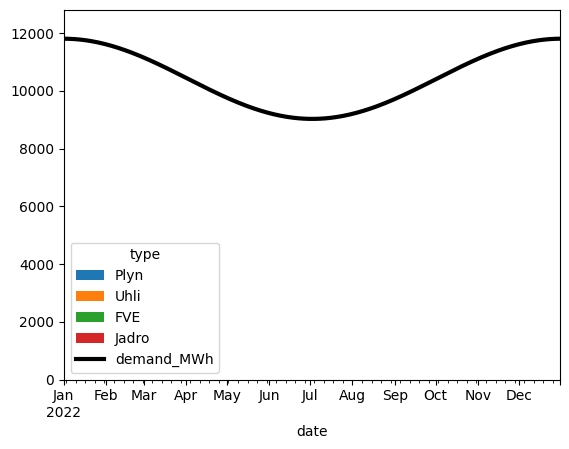

In [135]:
# bottom = 0
# fig, ax = plt.subplots()
# for t, group in plot_data.groupby("type"):
#     group.plot.bar(x="date", y="final_power", bottom=bottom, ax=ax)
#     bottom += group["final_power"]
ax = plot_data.pivot_table(values="final_power", index="date", columns="type").plot.bar(stacked=True)
es.demand.plot.line(ax=ax, color="black", lw=3, label="Demand")

In [26]:
# backup = supply_daily.copy()
# supply_daily = backup.copy()

In [40]:
supply_daily = supply_daily.merge(es.demand, left_on="date", right_on=es.demand.index)
supply_daily.sort_values(by=["date", "priority", "available", "block_no"], inplace=True)
supply_daily["total_power"] = supply_daily.groupby("date")["available_power"].cumsum()

In [42]:
supply_daily["to_kill"] = (supply_daily["total_power"] - supply_daily["power"]) > supply_daily["demand_MWh"]
supply_daily.head(30)

,date,type,block_no,power,priority,shutdown_prob,available,available_power,demand_MWh_x,demand_MWh_y,total_power,demand_MWh,to_kill
8,2022-01-01,FVE,0,2100,1,40,True,2100,11805.555556,11805.555556,2100,11805.555556,False
0,2022-01-01,Jadro,1,716,2,10,False,0,11805.555556,11805.555556,2100,11805.555556,False
1,2022-01-01,Jadro,3,716,2,10,False,0,11805.555556,11805.555556,2100,11805.555556,False
9,2022-01-01,Jadro,0,716,2,10,True,716,11805.555556,11805.555556,2816,11805.555556,False
10,2022-01-01,Jadro,2,716,2,10,True,716,11805.555556,11805.555556,3532,11805.555556,False
11,2022-01-01,Jadro,4,716,2,10,True,716,11805.555556,11805.555556,4248,11805.555556,False
12,2022-01-01,Jadro,5,716,2,10,True,716,11805.555556,11805.555556,4964,11805.555556,False
2,2022-01-01,Uhli,0,783,3,20,False,0,11805.555556,11805.555556,4964,11805.555556,False
3,2022-01-01,Uhli,2,783,3,20,False,0,11805.555556,11805.555556,4964,11805.555556,False
4,2022-01-01,Uhli,3,783,3,20,False,0,11805.555556,11805.555556,4964,11805.555556,False


In [86]:
len(np.linspace(0, 10, 11, endpoint=True))

11

In [95]:
"final_power".replace("_", " ").title()

'Final Power'

/tmp/ipykernel_2190/3989972635.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = supply_daily.groupby(["date", "type"]).sum()["final_power"].reset_index()


<Axes: xlabel='date', ylabel='Count'>

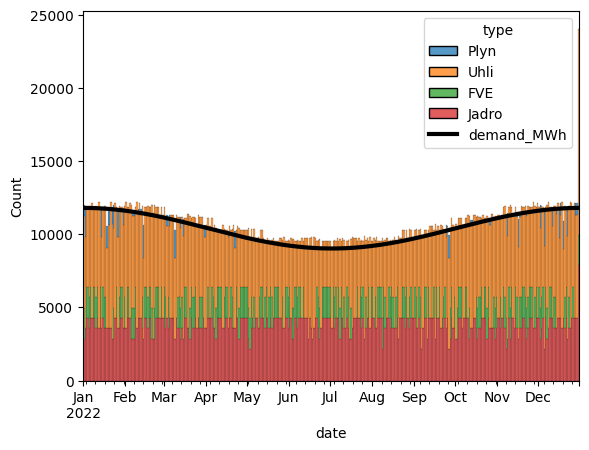

In [55]:
supply_daily = supply_daily.assign(final_power=lambda x: (~x.to_kill) * x.available_power)
supply_daily["type"] = pd.Categorical(supply_daily["type"], ["Jadro", "FVE", "Uhli", "Plyn"][::-1])
plot_data = supply_daily.groupby(["date", "type"]).sum()["final_power"].reset_index()
ax = sns.histplot(
    plot_data,
    binwidth=1,
    x="date",
    hue="type",
    weights="final_power",
    multiple="stack",
)
es.demand.plot.line(ax=ax, color="black", lw=3)

<Axes: xlabel='date', ylabel='missed'>

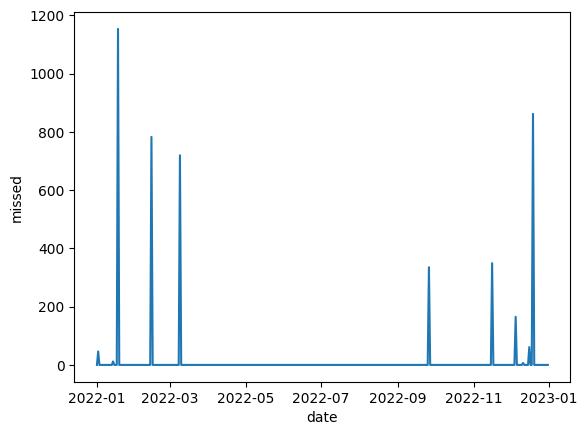

In [78]:
sns.lineplot(nedodavka, x="date", y="missed")

<Axes: xlabel='date', ylabel='Count'>

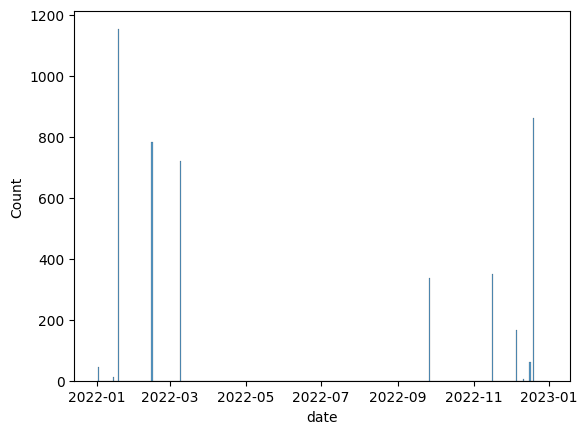

In [82]:
nedodavka = supply_daily.groupby("date")[["total_power", "demand_MWh"]].max()
nedodavka = nedodavka.assign(missed=lambda x: np.maximum(x.demand_MWh - x.total_power, 0))
nedodavka.reset_index(inplace=True)
sns.histplot(data=nedodavka, binwidth=1, x="date", weights="missed")

In [60]:
supply_daily.groupby("type")[["power", "available_power", "final_power"]].sum().assign(
    utilization_avail=lambda x: x.available_power / x.power * 100,
    utilization_final=lambda x: x.final_power / x.power * 100,
)

/tmp/ipykernel_2190/3251296575.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  supply_daily.groupby("type")[["power", "available_power", "final_power"]].sum().assign(utilization_avail=lambda x: x.available_power/x.power * 100, utilization_final=lambda x: x.final_power/x.power * 100)


,power,available_power,final_power,utilization_avail,utilization_final
type,,,,,
Plyn,838770,668335,47109,79.680365,5.616438
Uhli,3429540,2728755,2002914,79.566210,58.401826
FVE,766500,464100,464100,60.547945,60.547945
Jadro,1568040,1411236,1411236,90.000000,90.000000
